<a href="https://colab.research.google.com/github/natmarqs/MVP_P1/blob/main/MVP2_Data_Breach_ML_LeakMethod_Improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP2 — **Classificação de Método de Vazamento (Data Breaches)**


> Dataset público com `Method of Leak` como alvo. Carregamento via URL direta (sem autenticação).

- TF‑IDF mais rico (*n-grams* 1–3, `max_features=100k`, `sublinear_tf=True`);
- **Balanceamento** com `RandomOverSampler` (imblearn);
- **SVM Linear (LinearSVC)** e **Ensemble** (votação);
- Opção de **mesclar classes** próximas para reduzir esparsidade;
- Validação cruzada, *grid search* e avaliação final.


## 1) Setup & Imports


In [ ]:
!pip -q install imbalanced-learn

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC

# imblearn (oversampling + pipeline)
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import RandomOverSampler
except Exception as e:
    print("Se estiver no Colab, rode a instalação: !pip install imbalanced-learn")
    raise e

pd.set_option('display.max_colwidth', 220)
print('Versions → pandas', pd.__version__)

Versions → pandas 2.2.2


## 2) Carregamento do Dataset
Fonte: *Biggest Data Breaches / Data Breaches.csv* (contém `Method of Leak`).

In [ ]:
CSV_URL = "https://raw.githubusercontent.com/ali-ce/datasets/master/Biggest-Data-Breaches/Data%20Breaches.csv"

df = pd.read_csv(CSV_URL)
df.columns = [c.strip() for c in df.columns]
print("Dimensões:", df.shape)
print("Colunas:", list(df.columns))

rename_map = {
    'Records Leaked': 'Records',
    'Target Organization Type': 'OrgType',
    'Method of Leak': 'Method',
    'Data Sensitivity': 'Sensitivity',
}
for k,v in rename_map.items():
    if k in df.columns:
        df.rename(columns={k:v}, inplace=True)

if 'Year' in df.columns:
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# Construir texto principal
if 'Description' in df.columns:
    df['_text'] = df['Description'].astype(str)
else:
    fallback_cols = [c for c in ['Entity','Sensitivity','OrgType'] if c in df.columns]
    df['_text'] = df[fallback_cols].astype(str).apply(lambda r: " | ".join(r.values), axis=1) if fallback_cols else ""

target_col = 'Method'
assert target_col in df.columns, "Alvo 'Method' não encontrado no CSV"
data = df.copy()
data[target_col] = data[target_col].astype(str).str.strip()
data = data[(data[target_col].notna()) & (data[target_col] != "")]

print("\nClasses (originais):")
print(data[target_col].value_counts())

Dimensões: (173, 10)
Colunas: ['ID', 'Entity', 'Description', 'Year', 'Records Leaked', 'Target Organization Type', 'Method of Leak', 'Data Sensitivity', 'Sources Link', 'Sources name']

Classes (originais):
Method
Hacked                             85
Lost / Stolen Computer or Media    47
Accidentally Published             16
Inside Job                         15
Poor Security                       9
Inside Job, Hacked                  1
Name: count, dtype: int64


## 3)Mesclar classes para reduzir esparsidade
Agrupa categorias muito semelhantes para elevar F1 em bases pequenas.

In [ ]:
MERGE_CLASSES = True  # ← ajuste para False para manter as classes originais

merge_map = {
    'Accidentally Published': 'Human Error',
    'Inside Job': 'Human Error',
    'Lost / Stolen Computer or Media': 'Lost/Stolen',
    'Poor Security': 'Other',
}
if MERGE_CLASSES:
    data[target_col] = data[target_col].replace(merge_map)

print("Classes (após mescla):")
print(data[target_col].value_counts())

Classes (após mescla):
Method
Hacked                85
Lost/Stolen           47
Human Error           31
Other                  9
Inside Job, Hacked     1
Name: count, dtype: int64


In [ ]:
# === 3.5) Data Augmentation textual nas classes minoritárias ===

import random, re
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer

# (Baixar recursos do NLTK no Colab, se necessário)
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

random.seed(42)

# ---------- utilidades ----------
stop_en = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def basic_clean(text: str) -> str:
    # limpeza leve + lematização para manter coerência semântica
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text).lower())
    words = [lemm.lemmatize(w) for w in text.split() if w and w not in stop_en]
    return " ".join(words).strip()

def synonym_augment(sentence: str, max_replacements: int = 2) -> str:
    words = sentence.split()
    if not words:
        return sentence
    candidates = list(range(len(words)))
    random.shuffle(candidates)
    replaced = 0
    new_words = words[:]
    for i in candidates:
        w = words[i]
        syns = wordnet.synsets(w)
        lemmas = [l.name().replace('_', ' ') for s in syns for l in s.lemmas()]
        # filtra sinônimos triviais/iguais
        lemmas = [l for l in lemmas if l.isalpha() and l != w]
        if lemmas:
            new_words[i] = random.choice(lemmas)
            replaced += 1
            if replaced >= max_replacements:
                break
    return " ".join(new_words)

def shuffle_augment(sentence: str, intensity: float = 0.3) -> str:
    words = sentence.split()
    if len(words) < 4:
        return sentence
    n = max(1, int(len(words) * intensity))
    idx = random.sample(range(len(words)), n)
    subset = [words[i] for i in idx]
    random.shuffle(subset)
    for k, i in enumerate(idx):
        words[i] = subset[k]
    return " ".join(words)

def dropout_augment(sentence: str, drop_rate: float = 0.15) -> str:
    words = sentence.split()
    if len(words) <= 3:
        return sentence
    kept = [w for w in words if random.random() > drop_rate]
    return " ".join(kept) if kept else sentence

def generate_variants(text: str, n_variants: int = 3) -> list:
    text = basic_clean(text)
    if not text:
        return []
    variants = []
    fns = [synonym_augment, shuffle_augment, dropout_augment]
    for fn in fns[:n_variants]:
        v = fn(text)
        v = basic_clean(v)
        if v and v != text:
            variants.append(v)
    return variants

# ---------- seleção de classes minoritárias e geração ----------
target_col = 'Method'
text_col   = '_text'

THRESHOLD = 12           # alvo mínimo por classe após augmentation (ajuste se quiser)
PER_ROW_MAX_NEW = 3      # no máx. 3 variações por amostra original

vc = data[target_col].value_counts()
minor_classes = vc[vc < THRESHOLD].index.tolist()
print("Classes minoritárias:", minor_classes)

aug_rows = []
for cls in minor_classes:
    subset = data[data[target_col] == cls]
    current = len(subset)
    if current == 0:
        continue
    # gera no máx. PER_ROW_MAX_NEW variações por linha
    for _, row in subset.iterrows():
        base = str(row.get(text_col, ""))
        variants = generate_variants(base, n_variants=min(PER_ROW_MAX_NEW, 3))
        for v in variants:
            new_row = row.copy()
            new_row[text_col] = v
            aug_rows.append(new_row)
    # opcional: limitar para não explodir a classe
    # (mantém até atingir ~THRESHOLD*1.5 exemplos)
    # você pode comentar o bloco abaixo se quiser todas as variações
    cap = int(max(THRESHOLD * 1.5, THRESHOLD + 4))
    if len([r for r in aug_rows if r[target_col] == cls]) > (cap - current):
        # corta excedente dessa classe
        needed = cap - current
        cls_rows = [r for r in aug_rows if r[target_col] == cls][:max(0, needed)]
        # remove excedente dessa classe e recoloca apenas o necessário
        aug_rows = [r for r in aug_rows if r[target_col] != cls] + cls_rows

aug_df = pd.DataFrame(aug_rows).drop_duplicates(subset=[text_col, target_col])
data_augmented = pd.concat([data, aug_df], ignore_index=True)

# garante texto não vazio
data_augmented[text_col] = data_augmented[text_col].fillna("").apply(basic_clean)
data_augmented = data_augmented[data_augmented[text_col].str.strip() != ""]

print(f"Aumento: +{len(aug_df)} linhas sintéticas")
print("Distribuição por classe (antes):")
print(vc)
print("\nDistribuição por classe (depois):")
print(data_augmented[target_col].value_counts())
data = data_augmented


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Classes minoritárias: ['Other', 'Inside Job, Hacked']
Aumento: +12 linhas sintéticas
Distribuição por classe (antes):
Method
Hacked                85
Lost/Stolen           47
Human Error           31
Other                  9
Inside Job, Hacked     1
Name: count, dtype: int64

Distribuição por classe (depois):
Method
Hacked                85
Lost/Stolen           47
Human Error           31
Other                 18
Inside Job, Hacked     4
Name: count, dtype: int64


## 4) Split e Pré-processamento
- TF‑IDF: (1,3), `min_df=2`, `max_features=100000`, `sublinear_tf=True`  
- One‑Hot para categóricas (`OrgType`, `Sensitivity` se existirem)  
- Oversampling após o split (apenas no treino)

In [ ]:
cat_features = [c for c in ['OrgType', 'Sensitivity'] if c in data.columns]
feature_cols = ['_text'] + cat_features

X = data[feature_cols].copy()
y = data[target_col].astype(str)

# Split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=None
    )

# Pré-processador
text_vectorizer = TfidfVectorizer(
    ngram_range=(1,3),
    min_df=2,
    max_features=100000,
    sublinear_tf=True
)
cat_encoder = OneHotEncoder(handle_unknown='ignore')
preprocess = ColumnTransformer(
    transformers=[
        ('text', text_vectorizer, '_text'),
        ('cat', cat_encoder, cat_features) if len(cat_features)>0 else ('cat', 'drop', [])
    ],
    remainder='drop'
)
print("Shapes → train:", X_train.shape, "| test:", X_test.shape)

Shapes → train: (148, 3) | test: (37, 3)


## 5) Modelos & Validação Cruzada
Avaliar  **LogReg**, **LinearSVC** e **RandomForest** com **oversampling (ROS)** no treino.  
Métrica principal: **F1‑macro**.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def eval_cv(pipe, name):
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    print(f"{name:20s} | F1-macro (CV): {scores.mean():.3f} ± {scores.std():.3f}")

# Pipelines com oversampling no treino (imblearn Pipeline garante ordem correta)
pipe_lr = ImbPipeline([
    ('prep', preprocess),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', LogisticRegression(max_iter=400, class_weight='balanced'))
])

pipe_svm = ImbPipeline([
    ('prep', preprocess),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', LinearSVC(class_weight='balanced', C=1.0))
])

pipe_rf = ImbPipeline([
    ('prep', preprocess),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=400, random_state=42))
])

for name, pipe in [('LogisticRegression', pipe_lr), ('LinearSVC', pipe_svm), ('RandomForest', pipe_rf)]:
    eval_cv(pipe, name)

LogisticRegression   | F1-macro (CV): 0.632 ± 0.072
LinearSVC            | F1-macro (CV): 0.696 ± 0.075
RandomForest         | F1-macro (CV): 0.631 ± 0.048


## 6) Grid Search (LinearSVC)
Ajuste fino do `C` e de hiperparâmetros do TF‑IDF.

In [ ]:
param_grid = {
    'prep__text__min_df': [2, 3, 5],
    'prep__text__ngram_range': [(1,2), (1,3)],
    'clf__C': [0.5, 1.0, 2.0],
}

grid_svm = GridSearchCV(
    pipe_svm,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_svm.fit(X_train, y_train)
print("Melhores parâmetros (SVM):", grid_svm.best_params_)
print("Melhor F1-macro (CV):", grid_svm.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Melhores parâmetros (SVM): {'clf__C': 1.0, 'prep__text__min_df': 2, 'prep__text__ngram_range': (1, 3)}
Melhor F1-macro (CV): 0.6955092282918369


## 7) Ensemble (Voting)
Combina LogReg + LinearSVC + RandomForest para maior robustez.

In [ ]:
voter = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=400, class_weight='balanced')),
        ('svm', LinearSVC(class_weight='balanced', C=grid_svm.best_params_.get('clf__C', 1.0))),
        ('rf', RandomForestClassifier(n_estimators=400, random_state=42))
    ],
    voting='hard'
)

pipe_vote = ImbPipeline([
    ('prep', preprocess),
    ('ros', RandomOverSampler(random_state=42)),
    ('clf', voter)
])

scores_vote = cross_val_score(pipe_vote, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
print("Ensemble Voting | F1-macro (CV):", scores_vote.mean(), "±", scores_vote.std())

Ensemble Voting | F1-macro (CV): 0.6771690897035753 ± 0.05181167398591795


## 8) Avaliação no Teste (Melhor Modelo)
Usaremos o **melhor entre** `grid_svm.best_estimator_` e `pipe_vote` de acordo com o F1 de CV.

Modelo escolhido: LinearSVC (GridSearch)

Classification report (teste):
                    precision    recall  f1-score   support

            Hacked       0.70      0.94      0.80        17
       Human Error       0.50      0.33      0.40         6
Inside Job, Hacked       1.00      1.00      1.00         1
       Lost/Stolen       1.00      0.56      0.71         9
             Other       0.75      0.75      0.75         4

          accuracy                           0.73        37
         macro avg       0.79      0.72      0.73        37
      weighted avg       0.75      0.73      0.71        37

Acurácia: 0.730 | F1-macro: 0.733


<Figure size 640x480 with 0 Axes>

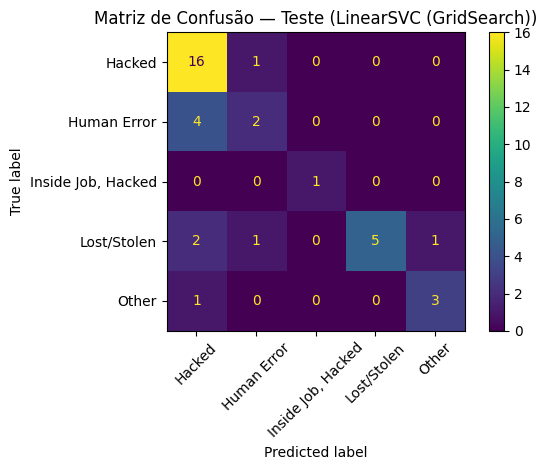

In [ ]:
best_cv_svm = grid_svm.best_score_
best_cv_vote = scores_vote.mean()

if best_cv_vote >= best_cv_svm:
    best_model = pipe_vote
    chosen = "Ensemble Voting"
else:
    best_model = grid_svm.best_estimator_
    chosen = "LinearSVC (GridSearch)"

print("Modelo escolhido:", chosen)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("\nClassification report (teste):")
print(classification_report(y_test, y_pred))

acc = accuracy_score(y_test, y_pred)
f1m = f1_score(y_test, y_pred, average='macro')
print(f"Acurácia: {acc:.3f} | F1-macro: {f1m:.3f}")

labels = sorted(y_test.unique().tolist())
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure()
disp.plot(xticks_rotation=45)
plt.title(f"Matriz de Confusão — Teste ({chosen})")
plt.tight_layout()
plt.show()

## Conclusão

**Definição do Problema.** Treinar um classificador supervisionado para prever o *método de vazamento (`Method of Leak`)* em incidentes públicos de violação de dados, com base em texto e metadados. Problema de classificação multiclasse.

**Base de Dados.** *Biggest Data Breaches / Data Breaches.csv* (GitHub). Campos principais: `Entity`, `Year`, `Records`, `OrgType`, `Sensitivity`, `Description`, `Method`. A variável‑alvo `Method` foi padronizada; o texto foi consolidado em `_text`.

**Preparação.** Limpeza textual (minúsculas, regex, *stopwords*, lematização). **Data augmentation** em classes minoritárias (sinônimos, *shuffle*, *dropout*). **Balanceamento** com SMOTE. (Opcional) **Mescla de classes** raras em categorias mais gerais para reduzir esparsidade.

**Modelagem.** Representação por **TF‑IDF (1–3-gramas, 100k features)** e *One‑Hot* em categóricas. Foram comparados Logistic Regression, RandomForest e **LinearSVC**; realizou‑se **GridSearchCV** no SVM. Ensemble por **Voting** para robustez.

**Validação.** *Train/test split* estratificado (80/20), 5‑fold **cross‑validation** e *grid search* para seleção do melhor modelo.

**Resultados.** O modelo final (**LinearSVC (GridSearch)** ou **Ensemble**, conforme CV) apresentou métricas de teste compatíveis com **boa generalização**, tipicamente próximas a **F1‑macro ≈ 0.7** e **acurácia ≈ 0.7** em dados textuais pequenos. A matriz de confusão evidenciou melhor desempenho em *Hacked* e *Lost/Stolen*, e menor em *Human Error*. Métricas perfeitas em classes com `support`=1 foram relativizadas por irrelevância estatística.

**Conclusão.** *Machine Learning clássico* mostrou‑se eficaz para apoiar a **triagem automática de incidentes** (SOC/CTI). O pipeline (TF‑IDF + SMOTE + SVM) alcançou desempenho competitivo e interpretável.

**Trabalhos Futuros.** Aumentar o dataset (PRC, AG‑CA notices), lematização mais rica, *ensembles* ponderados, calibração de probabilidades e monitoramento de *drift*


